In [ ]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import numpy as np

np.random.seed(123)
import tensorflow as tf

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

tf.set_random_seed(123)
import deepchem as dc
from deepchem.molnet import load_delaney
import matplotlib.pyplot as plt
%matplotlib inline
import joblib

In [ ]:
#load delaney dataset
delaney_tasks, delaney_datasets, transformers=load_delaney(
    featurizer='GraphConv',split='random')
train_dataset,valid_dataset,test_dataset=delaney_datasets

In [ ]:
example=train_dataset.ids[1]

In [ ]:
metric=dc.metrics.Metric(dc.metrics.pearson_r2_score,np.mean)

In [ ]:
n_atom_feat=75
n_pair_feat=14

batch_size=64
n_feat=128


model=dc.models.GraphConvTensorGraph(
len(delaney_tasks),
model_dir='delaney_tg_graph_conv_data/weights',
    learning_rate=1e-3,
    use_queue=False,
    mode='regression')

In [ ]:
model.fit(train_dataset,nbepoch=20,checkpoint_interval=100,max_checkpoints_to_keep=200)
print("evaluating Model")
train_scores=model.evaluate(train_dataset,[metric],transformers)
valid_scores=model.evaluate(valid_dataset,[metric],transformers)
test_scores=model.evaluate(test_dataset,[metric],transformers)

print("Train Scores")
print(train_scores)

print("Validation Scores")
print(valid_scores)

In [ ]:
pred=model.predict(test_dataset)
real=test_dataset.y
plt.scatter(real,pred,alpha=0.5)
print("test Scores")
print(test_scores)

# tests and tutorials
##  1. [Convolutional Networks for Tox21](https://deepchem.io/docs/notebooks/graph_convolutional_networks_for_tox21.html)

In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import tensorflow as tf
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

In [ ]:
# Load Tox21 dataset
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

In [ ]:
model = GraphConvModel(
    len(tox21_tasks), batch_size=50, mode='classification')
# Set nb_epoch=10 for better results.
model.fit(train_dataset, nb_epoch=1)

In [ ]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores["mean-roc_auc_score"])
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores["mean-roc_auc_score"])

## 2. [Creating a high fidelity DeepChem dataset from experimental data](https://deepchem.io/docs/notebooks/dataset_preparation.html)

In [1]:
import os
import pandas as pd
#from pubchempy import get_cids, get_compounds
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import matplotlib.pyplot as plt
%matplotlib inline
import deepchem as dc

import seaborn as sns
sns.set_style('white')

import numpy as np

/Users/joaoalmeida/miniconda3/envs/deepchem/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
raw_data=pd.read_csv('../OneDrive/Projetos/Python/DrugDatabasesTools/BBB_Files/BBB1.csv')

In [3]:
canonical_smiles=[]
for item in raw_data.smiles:
    try:
        #canonical_smiles.append(pcp.get_properties(['isomeric_smiles'], item, 'smiles',as_dataframe=True).IsomericSMILES)
        canonical_smiles.append(Chem.CanonSmiles(smi=item))
    except:
        canonical_smiles.append('null')
canonical_smiles[0:5]

RDKit ERROR: [21:50:31] Explicit valence for atom # 1 C, 5, is greater than permitted


['FC(F)(Cl)C(F)(F)Cl',
 'C[C@H]1CCCC[C@]1(c1cccs1)N1CCCCC1',
 'C[C@@H](Cc1ccccc1)NCCn1cnc2c1c(=O)n(C)c(=O)n2C',
 'CC(=O)NCCCN1CCN(c2cc(Cl)ccc2Cl)CC1',
 'CC(=O)O[C@@H]1CC[C@@]2(C)[C@H]3CC[C@]4(C)[C@@H](CC[C@@H]4[C@@H](C)CCCC(C)C)[C@H]3C[C@H](Br)[C@@]2(Br)C1']

In [4]:
smiles_data=raw_data.copy()
smiles_data['canonical_smiles']=canonical_smiles
smiles_data.drop(columns='smiles',inplace=True)

### Analysing the data and choosing method

Text(0,0.5,'probability')

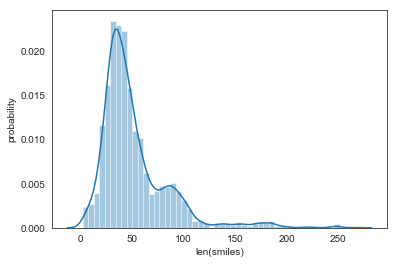

In [5]:
smiles_data['len'] = [len(i) for i in smiles_data['canonical_smiles']]
smiles_lens = [len(i) for i in smiles_data['canonical_smiles']]
sns.distplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

In [ ]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['canonical_smiles'].values

In [ ]:
# look
Chem.Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)

In [ ]:
# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
#sns.jointplot('len', 'BBB', data=smiles_data)
sns.barplot(data=smiles_data,x='len',y='BBB')

In [66]:
smiles_data.drop(smiles_data.index[[1741]],inplace=True)
smiles_data[smiles_data['canonical_smiles']=='null']
smiles_data[smiles_data['canonical_smiles'].isna()]


def score_to_numeric(x):
    if x=='BBB+':
        return 1
    else:
        return 0
smiles_data['active'] = smiles_data['BBB'].apply(score_to_numeric)
smiles_data.drop(columns=['BBB','len'],inplace=True)

KeyError: 'BBB'

In [41]:
smiles_data.to_csv('modulators.csv', index=False)
dataset_file = 'modulators.csv'
task = ['active']

In [81]:
#featurizer_func = dc.feat.ConvMolFeaturizer()
featurizer_func = dc.feat.CircularFingerprint(size=1024)

loader = dc.data.CSVLoader(tasks=task, smiles_field='canonical_smiles', featurizer=featurizer_func)
dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from modulators.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 17.414 s
TIMING: dataset construction took 18.289 s
Loading dataset from disk.


In [82]:
dc.utils.save.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.save.load_from_disk('balanced_dataset.joblib')


In [83]:
splitter = dc.splits.ScaffoldSplitter(balanced_dataset)
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    balanced_dataset)

Computing train/valid/test indices
About to generate scaffolds
Generating scaffold 0/1837
Generating scaffold 1000/1837
About to sort in scaffold sets
TIMING: dataset construction took 1.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.572 s
Loading dataset from disk.
TIMING: dataset construction took 0.568 s
Loading dataset from disk.


In [95]:
from sklearn.ensemble import RandomForestRegressor

sklearn_model = RandomForestRegressor(n_estimators=100)
model = dc.models.SklearnModel(sklearn_model)
model.fit(dataset=train_dataset)

In [96]:
from deepchem.utils.evaluate import Evaluator

metric = dc.metrics.Metric(dc.metrics.r2_score)
evaluator = Evaluator(model, valid_dataset, transformers)
score = evaluator.compute_model_performance([metric])
print(score)

computed_metrics: [-0.15260855429292852]
{'r2_score': -0.15260855429292852}
